# lg3 Fourier exogenous demo

Model a simple Fourier series using the same weekday from 1/2/3 weeks prior and compare to the target day.

In [50]:
import os
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- config ---
PROCESSED_ROOT = os.path.abspath(os.path.join('..', 'data', 'processed_sources'))
SOURCE = 'snu'  # elec1_f2 / ohsung_f2 / snu
SPLIT = 'train'  # train / val / test
TARGET_DATE = '2025-08-20'  # YYYY-MM-DD
COLUMN = 'Power'
FREQ = '5min'
FOURIER_K = 15
# number of steps per day (5min => 288)
FOURIER_S = 288
HOLIDAYS = {
    # '2025-09-15': 'Special Event',
}


In [51]:
def load_split(root, source, split):
    path = os.path.join(root, source, f'lg3_{split}.csv')
    df = pd.read_csv(path, parse_dates=[0], index_col=0)
    if COLUMN not in df.columns:
        raise ValueError(f'{COLUMN} not found in {path}')
    return df[[COLUMN]].sort_index()

def day_slice(df, day, freq):
    day_start = pd.to_datetime(day)
    day_end = day_start + timedelta(days=1) - timedelta(minutes=5)
    day_index = pd.date_range(day_start, day_end, freq=freq)
    out = df.loc[day_start:day_end].reindex(day_index)
    out[COLUMN] = out[COLUMN].interpolate(limit_direction='both')
    return out

df = load_split(PROCESSED_ROOT, SOURCE, SPLIT)
target_dt = datetime.strptime(TARGET_DATE, '%Y-%m-%d')
prior_dates = [target_dt - timedelta(days=7 * k) for k in (3, 2, 1)]

target_series = day_slice(df, target_dt, FREQ)
prior_series = [day_slice(df, d, FREQ) for d in prior_dates]

print('Target date:', target_dt.date())
print('Prior dates:', [d.date() for d in prior_dates])
for d in prior_dates + [target_dt]:
    label = HOLIDAYS.get(d.strftime('%Y-%m-%d'))
    if label:
        print(f'Holiday: {d.date()} -> {label}')

# quick head/tail preview for each day
for label, series in zip(['3w', '2w', '1w', 'target'], prior_series + [target_series]):
    print(f'[{label}] head:', series.head(3))
    print(f'[{label}] tail:', series.tail(3))


Target date: 2025-08-20
Prior dates: [datetime.date(2025, 7, 30), datetime.date(2025, 8, 6), datetime.date(2025, 8, 13)]
[3w] head:                       Power
2025-07-30 00:00:00  1.0998
2025-07-30 00:05:00  1.2458
2025-07-30 00:10:00  3.3540
[3w] tail:                       Power
2025-07-30 23:45:00  2.0016
2025-07-30 23:50:00  2.4796
2025-07-30 23:55:00  2.2000
[2w] head:                       Power
2025-08-06 00:00:00  2.6394
2025-08-06 00:05:00  2.7324
2025-08-06 00:10:00  2.8960
[2w] tail:                       Power
2025-08-06 23:45:00  3.5280
2025-08-06 23:50:00  3.4420
2025-08-06 23:55:00  3.4332
[1w] head:                       Power
2025-08-13 00:00:00  2.0134
2025-08-13 00:05:00  1.6460
2025-08-13 00:10:00  1.9088
[1w] tail:                       Power
2025-08-13 23:45:00  1.4370
2025-08-13 23:50:00  1.4722
2025-08-13 23:55:00  2.0682
[target] head:                       Power
2025-08-20 00:00:00  1.6632
2025-08-20 00:05:00  1.3862
2025-08-20 00:10:00  1.4880
[target] tail:

In [52]:
# ============================================================
# 2) Fourier fit on 3 prior weeks -> alpha/beta
# ============================================================
def fit_fourier_coeffs(y: np.ndarray, K: int = 20, s: float = 24.0):
    y = np.asarray(y, dtype=float).reshape(-1)
    T = len(y)
    t = np.arange(T, dtype=float)

    X = np.ones((T, 1 + 2*K), dtype=float)
    for k in range(1, K+1):
        X[:, k]     = np.sin(2*np.pi*k*t/s)
        X[:, K + k] = np.cos(2*np.pi*k*t/s)

    theta, *_ = np.linalg.lstsq(X, y, rcond=None)

    alpha0 = float(theta[0])
    alpha  = theta[1:1+K].copy()
    beta   = theta[1+K:1+2*K].copy()
    return alpha0, alpha, beta

def fourier_predict(T: int, alpha0: float, alpha: np.ndarray, beta: np.ndarray, s: float = 24.0):
    K = len(alpha)
    t = np.arange(T, dtype=float)
    yhat = alpha0 * np.ones(T, dtype=float)
    for k in range(1, K+1):
        yhat += alpha[k-1] * np.sin(2*np.pi*k*t/s)
        yhat += beta[k-1]  * np.cos(2*np.pi*k*t/s)
    return yhat

# concatenate prior 3 weeks (3 days) for fitting
prior_concat = np.concatenate([s[COLUMN].values for s in prior_series])
alpha0, alpha, beta = fit_fourier_coeffs(prior_concat, K=FOURIER_K, s=FOURIER_S)
print(f'[INFO] Fourier fitted on prior 3 weeks | K={FOURIER_K}, s={FOURIER_S}')

# predict for 4 days (3 prior + target)
day_steps = len(target_series)
total_steps = day_steps * 4
fourier_all = fourier_predict(T=total_steps, alpha0=alpha0, alpha=alpha, beta=beta, s=FOURIER_S)

# build concat series for plotting
all_series = prior_series + [target_series]
concat_values = np.concatenate([s[COLUMN].values for s in all_series])

# quick sanity checks
for label, series in zip(['3w', '2w', '1w', 'target'], all_series):
    nan_count = np.isnan(series[COLUMN].values).sum()
    print(f'[INFO] {label} NaNs: {nan_count} / {len(series)}')


[INFO] Fourier fitted on prior 3 weeks | K=15, s=288
[INFO] 3w NaNs: 0 / 288
[INFO] 2w NaNs: 0 / 288
[INFO] 1w NaNs: 0 / 288
[INFO] target NaNs: 0 / 288


In [53]:
# compute error on target segment
target_start = day_steps * 3
target_end = day_steps * 4
target_pred = fourier_all[target_start:target_end]
target_true = target_series[COLUMN].values
mse = np.mean((target_true - target_pred) ** 2)
mae = np.mean(np.abs(target_true - target_pred))
print(f'[INFO] Target MSE: {mse:.6f} | MAE: {mae:.6f}')


[INFO] Target MSE: 1.167498 | MAE: 0.941330


day_steps: 288 total_steps: 1152
concat_values len: 1152 fourier len: 1152


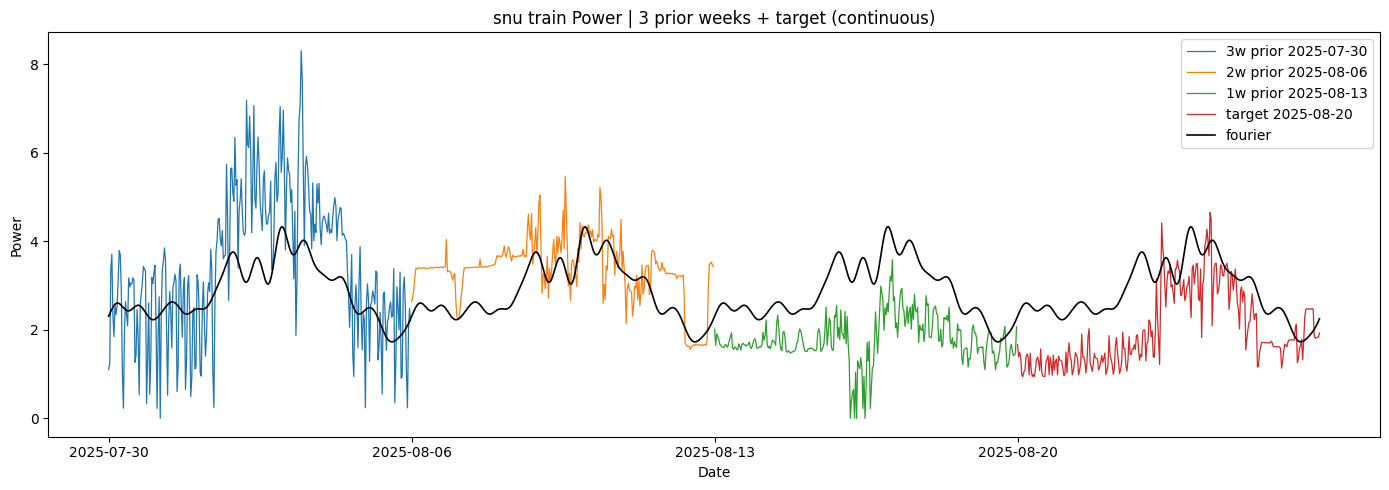

In [54]:
# debug lengths
print('day_steps:', day_steps, 'total_steps:', total_steps)
print('concat_values len:', len(concat_values), 'fourier len:', len(fourier_all))

labels = [f'3w prior {prior_dates[0].date()}', f'2w prior {prior_dates[1].date()}', f'1w prior {prior_dates[2].date()}', f'target {target_dt.date()}']

# build a continuous 4-day index starting from the oldest prior day
start_day = prior_dates[0].date()
continuous_index = pd.date_range(start=pd.to_datetime(start_day), periods=total_steps, freq=FREQ)

plt.figure(figsize=(14, 5))

# plot the 4 concatenated days as colored segments
for i, (color, label) in enumerate(zip(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], labels)):
    start = i * day_steps
    end = (i + 1) * day_steps
    plt.plot(continuous_index[start:end], concat_values[start:end], color=color, linewidth=0.9, label=label)

# overlay Fourier prediction
plt.plot(continuous_index, fourier_all, color='black', linewidth=1.2, label='fourier')

# mark day boundaries with date labels
boundary_positions = [continuous_index[i * day_steps] for i in range(4)]
boundary_labels = [d.strftime('%Y-%m-%d') for d in prior_dates + [target_dt]]
plt.xticks(boundary_positions, boundary_labels, rotation=0)

plt.title(f'{SOURCE} {SPLIT} {COLUMN} | 3 prior weeks + target (continuous)')
plt.xlabel('Date')
plt.ylabel(COLUMN)
plt.legend()
plt.tight_layout()
plt.show()
